## import

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

## load the data

In [39]:
# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- 1) Fresh load (avoid any prior state) ---
URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(URL, parse_dates=["Date"]).rename(columns={"Date":"date","Temp":"tmin_c"})
df = df.sort_values("date", ignore_index=True)
df = df.set_index("date").asfreq("D")  # enforce daily frequency

## Basic cleanup / standardization

In [40]:
if df.isna().any().any():
    df = df.dropna()

print("Shape:", df.shape)
print("Date range:", df.index.min().date(), "→", df.index.max().date())
print("Inferred frequency:", pd.infer_freq(df.index))

Shape: (3650, 1)
Date range: 1981-01-01 → 1990-12-31
Inferred frequency: None


## Basic descriptive stats (temperature in °C)

In [42]:
print(df["tmin_c"].describe())

count    3650.000000
mean       11.177753
std         4.071837
min         0.000000
25%         8.300000
50%        11.000000
75%        14.000000
max        26.300000
Name: tmin_c, dtype: float64


## Quick plausibility checks

In [44]:
print("Any temps below -10°C? ", (df["tmin_c"] < -10).any())
print("Any temps above 35°C?  ", (df["tmin_c"] > 35).any())

Any temps below -10°C?  False
Any temps above 35°C?   False


## Peek at the first 5 rows

In [45]:
print(df.head().to_string(index=False))

 tmin_c
   20.7
   17.9
   18.8
   14.6
   15.8


## Prepare the Series for RNN Input

## Train / Validation / Test Split

In [43]:
n = len(df)
train_df = df.iloc[:int(0.8*n)].copy()
val_df   = df.iloc[int(0.8*n):int(0.9*n)].copy()
test_df  = df.iloc[int(0.9*n):].copy()

print("Split:",
      "\n Train:", train_df.index.min().date(), "→", train_df.index.max().date(),
      "\n Val:  ", val_df.index.min().date(),   "→", val_df.index.max().date(),
      "\n Test: ", test_df.index.min().date(),  "→", test_df.index.max().date())

Split: 
 Train: 1981-01-01 → 1988-12-30 
 Val:   1989-01-01 → 1989-12-31 
 Test:  1990-01-01 → 1990-12-31


## Normalize Temperatures

In [47]:
scaler = MinMaxScaler()
train_df.loc[:, "tmin_scaled"] = scaler.fit_transform(train_df[["tmin_c"]])
val_df.loc[:,   "tmin_scaled"] = scaler.transform(val_df[["tmin_c"]])
test_df.loc[:,  "tmin_scaled"] = scaler.transform(test_df[["tmin_c"]])

In [48]:
# Defensive: drop NaNs if any remain after scaling
train_df = train_df.dropna()
val_df   = val_df.dropna()
test_df  = test_df.dropna()

## Create Sliding Windows

In [49]:
def make_sequences_no_nan(dataframe: pd.DataFrame, window: int = 7):
    vals = dataframe["tmin_scaled"].values.astype(np.float32)
    X, y = [], []
    for i in range(window, len(vals)):
        win = vals[i-window:i]
        target = vals[i]
        if np.isnan(win).any() or np.isnan(target):
            continue
        X.append(win)
        y.append(target)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

WINDOW = 7
X_train, y_train = make_sequences_no_nan(train_df, WINDOW)
X_val,   y_val   = make_sequences_no_nan(val_df,   WINDOW)
X_test,  y_test  = make_sequences_no_nan(test_df,  WINDOW)

print("Shapes:",
      "\n X_train", X_train.shape, " y_train", y_train.shape,
      "\n X_val  ", X_val.shape,   " y_val  ", y_val.shape,
      "\n X_test ", X_test.shape,  " y_test ", y_test.shape)

print("NaNs check:",
      "\n X_train", np.isnan(X_train).sum(), " y_train", np.isnan(y_train).sum(),
      "\n X_val  ", np.isnan(X_val).sum(),   " y_val  ", np.isnan(y_val).sum(),
      "\n X_test ", np.isnan(X_test).sum(),  " y_test ", np.isnan(y_test).sum())

Shapes: 
 X_train (2913, 7)  y_train (2913,) 
 X_val   (358, 7)  y_val   (358,) 
 X_test  (358, 7)  y_test  (358,)
NaNs check: 
 X_train 0  y_train 0 
 X_val   0  y_val   0 
 X_test  0  y_test  0


## Feedforward Neural Network (Baseline)

In [50]:
ff_model = Sequential([
    Input(shape=(WINDOW,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

ff_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history_ff = ff_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=1
)

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0162 - mae: 0.0946 - val_loss: 0.0071 - val_mae: 0.0673
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0094 - mae: 0.0760 - val_loss: 0.0069 - val_mae: 0.0664
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0092 - mae: 0.0754 - val_loss: 0.0069 - val_mae: 0.0663
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0092 - mae: 0.0751 - val_loss: 0.0069 - val_mae: 0.0660
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0091 - mae: 0.0749 - val_loss: 0.0068 - val_mae: 0.0658
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0091 - mae: 0.0749 - val_loss: 0.0068 - val_mae: 0.0658
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0091 - mae: 0.0748 - val_loss: 0.0068 - val_mae: 0.0658
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0091 - mae: 0.0748 - val_loss: 0.0068 - val_mae: 0.0658
Epoch 9/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - lo

## Evaluate (scaled MAE + °C MAE)

In [51]:
# Scaled
loss, mae_scaled = ff_model.evaluate(X_test, y_test, verbose=0)

# Convert predictions back to °C for interpretability
y_pred_scaled = ff_model.predict(X_test, verbose=0).reshape(-1, 1)
y_true_scaled = y_test.reshape(-1, 1)

# Inverse-transform using the original scaler
y_pred_c = scaler.inverse_transform(y_pred_scaled)
y_true_c = scaler.inverse_transform(y_true_scaled)
mae_c = mean_absolute_error(y_true_c, y_pred_c)

print(f"\nFeedforward NN Test MAE (scaled): {mae_scaled:.4f}")
print(f"Feedforward NN Test MAE (°C):     {mae_c:.3f}")


Feedforward NN Test MAE (scaled): 0.0678
Feedforward NN Test MAE (°C):     1.784


## Training curves

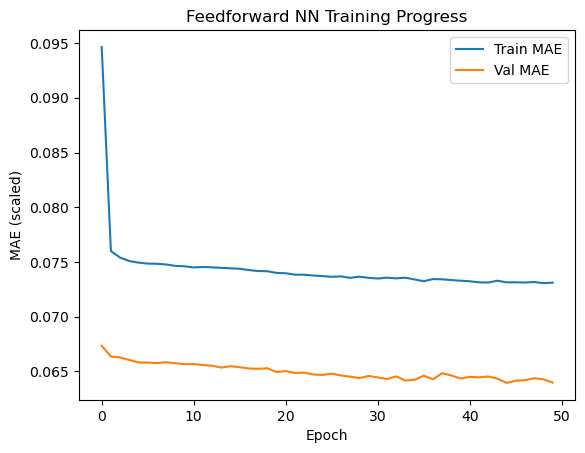

In [52]:
plt.plot(history_ff.history['mae'], label='Train MAE')
plt.plot(history_ff.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE (scaled)')
plt.title('Feedforward NN Training Progress')
plt.legend(); plt.show()

## Build & train the RNN

### Reshape to (samples, time_steps, features)

In [53]:
X_train_rnn = X_train.reshape(-1, WINDOW, 1).astype(np.float32)
X_val_rnn   = X_val.reshape(-1, WINDOW, 1).astype(np.float32)
X_test_rnn  = X_test.reshape(-1, WINDOW, 1).astype(np.float32)

print("RNN shapes:",
      "\n X_train_rnn", X_train_rnn.shape,
      "\n X_val_rnn  ", X_val_rnn.shape,
      "\n X_test_rnn ", X_test_rnn.shape)

RNN shapes: 
 X_train_rnn (2913, 7, 1) 
 X_val_rnn   (358, 7, 1) 
 X_test_rnn  (358, 7, 1)


### Build the LSTM model

In [56]:
tf.random.set_seed(42)
rnn_model = Sequential([
    Input(shape=(WINDOW, 1)),
    LSTM(32, return_sequences=False),  # capture temporal patterns
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='mse',
                  metrics=['mae'])
rnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

### Train with early stopping

In [60]:
es = EarlyStopping(monitor='val_mae', patience=8, mode='min', restore_best_weights=True)
history_rnn = rnn_model.fit(
    X_train_rnn, y_train,
    validation_data=(X_val_rnn, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0090 - mae: 0.0742 - val_loss: 0.0066 - val_mae: 0.0652
Epoch 2/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0090 - mae: 0.0741 - val_loss: 0.0066 - val_mae: 0.0652
Epoch 3/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0090 - mae: 0.0740 - val_loss: 0.0066 - val_mae: 0.0653
Epoch 4/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0090 - mae: 0.0741 - val_loss: 0.0066 - val_mae: 0.0653
Epoch 5/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0090 - mae: 0.0740 - val_loss: 0.0066 - val_mae: 0.0652
Epoch 6/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0090 - mae: 0.0740 - val_loss: 0.0066 - val_mae: 0.0654
Epoch 7/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0090 - mae: 0.0740 - val_loss: 0.0066 - val_mae: 0.0652
Epoch 8/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0090 - mae: 0.0740 - val_loss: 0.0066 - val_mae: 0.0653
Epoch 9/100
183/183 ━━━━━━━━━━━━━━━━━━━━ 

### Evaluate (scaled MAE and °C MAE)

In [61]:
loss_rnn, mae_rnn_scaled = rnn_model.evaluate(X_test_rnn, y_test, verbose=0)

y_pred_scaled = rnn_model.predict(X_test_rnn, verbose=0).reshape(-1, 1)
y_true_scaled = y_test.reshape(-1, 1)

### inverse-scale to °C

In [62]:
y_pred_c = scaler.inverse_transform(y_pred_scaled)
y_true_c = scaler.inverse_transform(y_true_scaled)
mae_rnn_c = mean_absolute_error(y_true_c, y_pred_c)

print(f"\nRNN (LSTM) Test MAE (scaled): {mae_rnn_scaled:.4f}")
print(f"RNN (LSTM) Test MAE (°C):     {mae_rnn_c:.3f}")


RNN (LSTM) Test MAE (scaled): 0.0668
RNN (LSTM) Test MAE (°C):     1.758


### Training curves

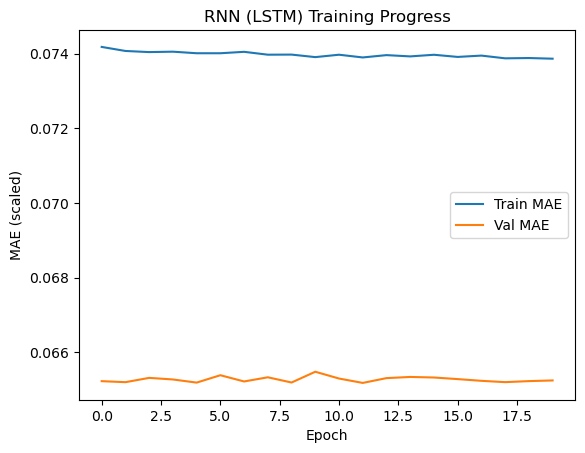

In [63]:
plt.figure()
plt.plot(history_rnn.history['mae'], label='Train MAE')
plt.plot(history_rnn.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE (scaled)')
plt.title('RNN (LSTM) Training Progress')
plt.legend(); plt.show()

### Visualize predictions vs actuals

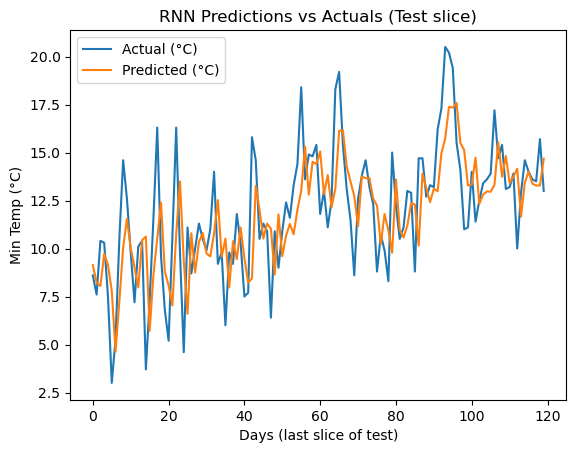

In [64]:
slice_len = 120  # last ~4 months of test period; adjust as you like
plt.figure()
plt.plot(y_true_c[-slice_len:], label='Actual (°C)')
plt.plot(y_pred_c[-slice_len:], label='Predicted (°C)')
plt.xlabel('Days (last slice of test)')
plt.ylabel('Min Temp (°C)')
plt.title('RNN Predictions vs Actuals (Test slice)')
plt.legend(); plt.show()

Shapes: 
  X_train_rnn2 (2906, 14, 3)  y_train2 (2906,) 
  X_val_rnn2   (351, 14, 3)  y_val2   (351,) 
  X_test_rnn2  (351, 14, 3)  y_test2  (351,)
NaNs: 0 0 0 0 0 0



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,465 (72.13 KB)

 Trainable params: 18,465 (72.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - loss: 0.0220 - mae: 0.1122 - val_loss: 0.0121 - val_mae: 0.0865 - learning_rate: 0.0010
Epoch 2/120
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0131 - mae: 0.0891 - val_loss: 0.0147 - val_mae: 0.0951 - learning_rate: 0.0010
Epoch 3/120
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0126 - mae: 0.0877 - val_loss: 0.0141 - val_mae: 0.0937 - learning_rate: 0.0010
Epoch 4/120
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0117 - mae: 0.0840 - val_loss: 0.0149 - val_mae: 0.0963 - learning_rate: 0.0010
Epoch 5/120
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0116 - mae: 0.0849 - val_loss: 0.0127 - val_mae: 0.0888 - learning_rate: 0.0010
Epoch 6/120
90/91 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0111 - mae: 0.0829
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0112 - mae: 0.0828 - val_loss: 0.0132 - val_mae: 0.0909 - learning_rate: 0.0010
Ep

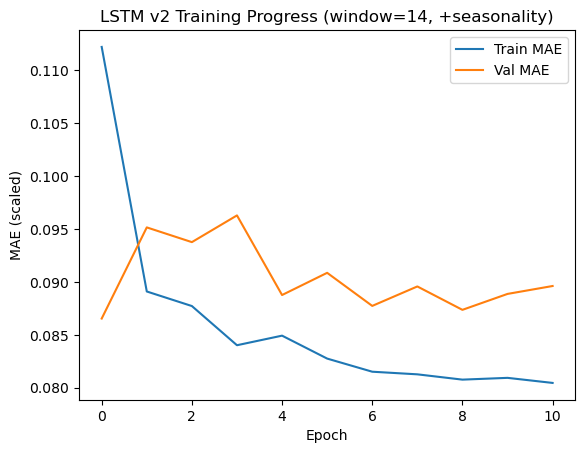

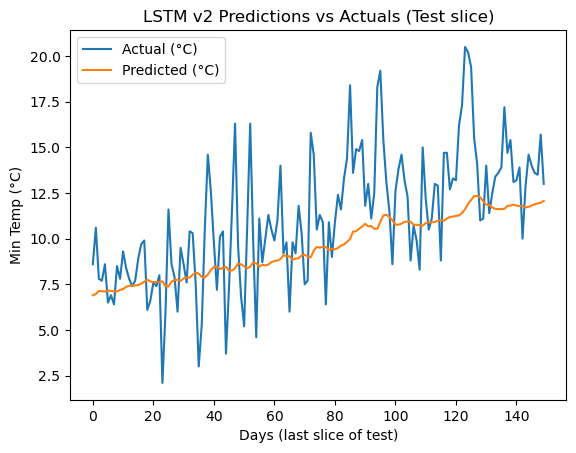

In [65]:
# ============================================================
# LSTM v2 (better): window=14, seasonality features, regularization,
# LR scheduling + early stopping, and °C evaluation
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import mean_absolute_error

tf.random.set_seed(42)
np.random.seed(42)

# ---------- 1) Add seasonality features (sine/cosine of day-of-year) ----------
def add_seasonal_features(df):
    # day-of-year in [1..366]; use 365.25 to be robust around leap years
    doy = df.index.dayofyear.values.astype(np.float32)
    df = df.copy()
    df["sin_doy"] = np.sin(2 * np.pi * doy / 365.25)
    df["cos_doy"] = np.cos(2 * np.pi * doy / 365.25)
    return df

train_ex = add_seasonal_features(train_df)
val_ex   = add_seasonal_features(val_df)
test_ex  = add_seasonal_features(test_df)

# ---------- 2) Make multivariate sliding windows (skip any with NaNs) ----------
def make_multivar_sequences_no_nan(df, window, feature_cols, target_col="tmin_scaled"):
    X, y = [], []
    V = df[feature_cols + [target_col]].values.astype(np.float32)
    f = len(feature_cols)
    for i in range(window, len(V)):
        win = V[i-window:i, :f]     # (window, features)
        target = V[i, f]            # scalar
        if np.isnan(win).any() or np.isnan(target):
            continue
        X.append(win)
        y.append(target)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

FEATURES = ["tmin_scaled", "sin_doy", "cos_doy"]
WINDOW2  = 14

X_train_rnn2, y_train2 = make_multivar_sequences_no_nan(train_ex, WINDOW2, FEATURES)
X_val_rnn2,   y_val2   = make_multivar_sequences_no_nan(val_ex,   WINDOW2, FEATURES)
X_test_rnn2,  y_test2  = make_multivar_sequences_no_nan(test_ex,  WINDOW2, FEATURES)

print("Shapes:",
      "\n  X_train_rnn2", X_train_rnn2.shape, " y_train2", y_train2.shape,
      "\n  X_val_rnn2  ", X_val_rnn2.shape,   " y_val2  ", y_val2.shape,
      "\n  X_test_rnn2 ", X_test_rnn2.shape,  " y_test2 ", y_test2.shape)

print("NaNs:",
      np.isnan(X_train_rnn2).sum(), np.isnan(y_train2).sum(),
      np.isnan(X_val_rnn2).sum(),   np.isnan(y_val2).sum(),
      np.isnan(X_test_rnn2).sum(),  np.isnan(y_test2).sum())

# ---------- 3) Build stronger LSTM with regularization ----------
tf.keras.backend.clear_session()
rnn2 = Sequential([
    Input(shape=(WINDOW2, len(FEATURES))),
    LSTM(64, dropout=0.2, recurrent_dropout=0.1, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

rnn2.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
             loss='mse',
             metrics=['mae'])

rnn2.summary()

# ---------- 4) Train with LR schedule + early stopping ----------
callbacks = [
    ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True, verbose=1)
]

hist2 = rnn2.fit(
    X_train_rnn2, y_train2,
    validation_data=(X_val_rnn2, y_val2),
    epochs=120,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# ---------- 5) Evaluate: scaled MAE + °C MAE ----------
loss2, mae_scaled2 = rnn2.evaluate(X_test_rnn2, y_test2, verbose=0)

y_pred2_scaled = rnn2.predict(X_test_rnn2, verbose=0).reshape(-1, 1)
y_true2_scaled = y_test2.reshape(-1, 1)

y_pred2_c = scaler.inverse_transform(y_pred2_scaled)
y_true2_c = scaler.inverse_transform(y_true2_scaled)
mae_c2 = mean_absolute_error(y_true2_c, y_pred2_c)

print(f"\nLSTM v2 Test MAE (scaled): {mae_scaled2:.4f}")
print(f"LSTM v2 Test MAE (°C):     {mae_c2:.3f}")

# ---------- 6) Training curves ----------
plt.figure()
plt.plot(hist2.history['mae'], label='Train MAE')
plt.plot(hist2.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch'); plt.ylabel('MAE (scaled)')
plt.title('LSTM v2 Training Progress (window=14, +seasonality)')
plt.legend(); plt.show()

# ---------- 7) Predictions vs Actuals (test slice) ----------
slice_len = 150
plt.figure()
plt.plot(y_true2_c[-slice_len:], label='Actual (°C)')
plt.plot(y_pred2_c[-slice_len:], label='Predicted (°C)')
plt.xlabel('Days (last slice of test)')
plt.ylabel('Min Temp (°C)')
plt.title('LSTM v2 Predictions vs Actuals (Test slice)')
plt.legend(); plt.show()


## Side-by-side comparison (FNN vs. RNN)

### Feedforward predictions 

In [66]:
y_pred_ff_scaled = ff_model.predict(X_test, verbose=0).reshape(-1, 1)
y_true_ff_scaled = y_test.reshape(-1, 1)

y_pred_ff_c = scaler.inverse_transform(y_pred_ff_scaled)
y_true_ff_c = scaler.inverse_transform(y_true_ff_scaled)
mae_ff_c = mean_absolute_error(y_true_ff_c, y_pred_ff_c)

### RNN (best) predictions 

In [67]:
y_pred_rnn_scaled = rnn2.predict(X_test_rnn2, verbose=0).reshape(-1, 1)
y_true_rnn_scaled = y_test2.reshape(-1, 1)

y_pred_rnn_c = scaler.inverse_transform(y_pred_rnn_scaled)
y_true_rnn_c = scaler.inverse_transform(y_true_rnn_scaled)
mae_rnn_c = mean_absolute_error(y_true_rnn_c, y_pred_rnn_c)

### scaled MAEs

In [69]:
mae_ff_scaled  = mean_absolute_error(y_true_ff_scaled,  y_pred_ff_scaled)
mae_rnn_scaled = mean_absolute_error(y_true_rnn_scaled, y_pred_rnn_scaled)

In [70]:
results = pd.DataFrame({
    "Model": ["Feedforward (7-day)", "LSTM v2 (14-day + seasonality)"],
    "MAE (scaled)": [mae_ff_scaled, mae_rnn_scaled],
    "MAE (°C)":     [mae_ff_c,      mae_rnn_c]
})
print(results.to_string(index=False))

                         Model  MAE (scaled)  MAE (°C)
           Feedforward (7-day)      0.067832  1.783982
LSTM v2 (14-day + seasonality)      0.089383  2.350762


### Overlay predictions vs actuals

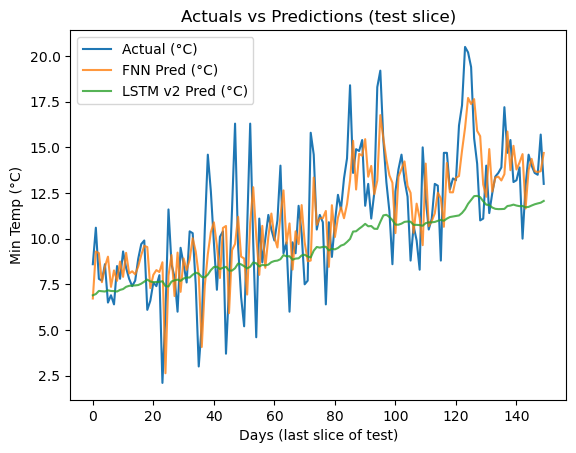

In [71]:
slice_len = 150  # ~5 months; adjust as you like
plt.figure()
plt.plot(y_true_rnn_c[-slice_len:], label="Actual (°C)")
plt.plot(y_pred_ff_c[-slice_len:],  label="FNN Pred (°C)", alpha=0.8)
plt.plot(y_pred_rnn_c[-slice_len:], label="LSTM v2 Pred (°C)", alpha=0.8)
plt.xlabel("Days (last slice of test)"); plt.ylabel("Min Temp (°C)")
plt.title("Actuals vs Predictions (test slice)")
plt.legend(); plt.show()

The actual series is noisy with frequent sharp spikes/dips.

The FNN (orange) tracks many short-term rises and drops but still lags on sudden extremes (typical for one-step regression).

The LSTM v2 (green) is smoother: it follows the overall upward trend/seasonal rise but reacts less to day-to-day volatility.


FNN treats each 7-day window independently (no recurrent state). It behaves like a learned autoregressive smoother: decent at local patterns, limited memory beyond the window, and prone to under/overshoot sharp changes.

LSTM keeps temporal memory across the 14-step sequence and benefits from seasonality features, so it captures trend/seasonal level better. Its built-in regularization and longer window often produce less noisy predictions, hence the smoother line.